# Training a GIF network for working memory tasks

In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import tqdm
import jax

import brainpy as bp
import brainpy.math as bm
import brainpy_datasets as bd

In [2]:
bp.math.set(dt=1., mode=bm.training_mode)

## Delayed match-to-sample task

In [3]:
@bp.tools.numba_jit
def _dms(num_steps, num_inputs, n_motion_choice, motion_tuning, is_spiking_mode,
         sample_time, test_time, fr, bg_fr, rotate_dir):
  # data
  X = np.zeros((num_steps, num_inputs))

  # sample
  match = np.random.randint(2)
  sample_dir = np.random.randint(n_motion_choice)

  # Generate the sample and test stimuli based on the rule
  if match == 1:  # match trial
    test_dir = (sample_dir + rotate_dir) % n_motion_choice
  else:
    test_dir = np.random.randint(n_motion_choice)
    while test_dir == ((sample_dir + rotate_dir) % n_motion_choice):
      test_dir = np.random.randint(n_motion_choice)

  # SAMPLE stimulus
  X[sample_time] += motion_tuning[sample_dir] * fr
  # TEST stimulus
  X[test_time] += motion_tuning[test_dir] * fr
  X += bg_fr

  # to spiking
  if is_spiking_mode:
    X = np.random.random(X.shape) < X
    X = X.astype(np.float_)

  # can use a greater weight for test period if needed
  return X, match

In [4]:
_rotate_choice = {
  '0': 0,
  '45': 1,
  '90': 2,
  '135': 3,
  '180': 4,
  '225': 5,
  '270': 6,
  '315': 7,
  '360': 8,
}

In [5]:
class DMS(bd.cognitive.CognitiveTask):
  times = ('dead', 'fixation', 'sample', 'delay', 'test')
  output_features = ('non-match', 'match')

  def __init__(
      self,
      dt=100., t_fixation=500., t_sample=500., t_delay=1000., t_test=500.,
      limits=(0., np.pi * 2), rotation_match='0', kappa=2,
      bg_fr=1., ft_motion=bd.cognitive.Feature(24, 100, 40.),
      num_trial=1024, mode='rate', seed=None,
  ):
    super().__init__(dt=dt, num_trial=num_trial, seed=seed)
    # time
    self.t_fixation = int(t_fixation / dt)
    self.t_sample = int(t_sample / dt)
    self.t_delay = int(t_delay / dt)
    self.t_test = int(t_test / dt)
    self.num_steps = self.t_fixation + self.t_sample + self.t_delay + self.t_test
    self._times = {
      'fixation': self.t_fixation,
      'sample': self.t_sample,
      'delay': self.t_delay,
      'test': self.t_test,
    }
    test_onset = self.t_fixation + self.t_sample + self.t_delay
    self.test_time = slice(test_onset, test_onset + self.t_test)
    self.fix_time = slice(0, test_onset)
    self.sample_time = slice(self.t_fixation, self.t_fixation + self.t_sample)

    # input shape
    self.features = ft_motion.set_name('motion')
    self.features.set_mode(mode)
    self.rotation_match = rotation_match
    self._rotate = _rotate_choice[rotation_match]
    self.bg_fr = bg_fr  # background firing rate
    self.v_min = limits[0]
    self.v_max = limits[1]
    self.v_range = limits[1] - limits[0]

    # Tuning function data
    self.n_motion_choice = 8
    self.kappa = kappa  # concentration scaling factor for von Mises

    # Generate list of preferred directions
    # dividing neurons by 2 since two equal
    # groups representing two modalities
    pref_dirs = np.arange(self.v_min, self.v_max, self.v_range / ft_motion.num)

    # Generate list of possible stimulus directions
    stim_dirs = np.arange(self.v_min, self.v_max, self.v_range / self.n_motion_choice)

    d = np.cos(np.expand_dims(stim_dirs, 1) - pref_dirs)
    self.motion_tuning = np.exp(self.kappa * d) / np.exp(self.kappa)

  @property
  def num_inputs(self) -> int:
    return self.features.num

  @property
  def num_outputs(self) -> int:
    return 2

  def sample_a_trial(self, index):
    fr = self.features.fr(self.dt)
    bg_fr = bd.cognitive.firing_rate(self.bg_fr, self.dt, self.features.mode)
    return _dms(self.num_steps, self.num_inputs, self.n_motion_choice,
                self.motion_tuning, self.features.is_spiking_mode,
                self.sample_time, self.test_time, fr, bg_fr, self._rotate)


## Visualization

In [6]:
def verify_lif(net, ds, fn=None, num_show=5, sps_inc=10.):
  if fn is not None:
    states = bp.checkpoints.load_pytree(fn)
    net.load_state_dict(states['net'])

  # looping the model over time
  outs = (net.r.spike, net.r.V)
  looper = bp.LoopOverTime(net, out_vars=outs)

  for i in range(num_show):
    fig, gs = bp.visualize.get_figure(4, 1, 2., 10.)

    x, _ = ds[i]
    ts = np.arange(0, x.shape[0]) * ds.dt
    max_t = x.shape[0] * ds.dt

    # insert empty row
    ax_inp = fig.add_subplot(gs[0, 0])
    indices, times = bp.measure.raster_plot(x, ts)
    ax_inp.plot(times, indices, '.')
    # bp.visualize.raster_plot(ts, x, xlim=(0., max_t), ax=ax_inp)
    ax_inp.set_xlim(0., max_t)
    ax_inp.set_ylabel('Input Activity')

    looper.reset_state(1)
    readout, rrr = looper(np.expand_dims(x, 1))
    spikes, mems = rrr[:2]

    ax = fig.add_subplot(gs[1, 0])
    mems = bm.as_numpy(bm.where(spikes, mems + sps_inc, mems))
    for i in range(0, net.r.num, 10):
      plt.plot(ts, mems[:, 0, i])
    ax.set_xlim(0., max_t)
    ax.set_ylabel('Recurrent Potential')

    # spiking activity
    ax_rec = fig.add_subplot(gs[2, 0])
    indices, times = bp.measure.raster_plot(spikes[:, 0], ts)
    ax_rec.plot(times, indices, '.')
    ax_rec.set_xlim(0., max_t)
    ax_rec.set_ylabel('Recurrent Spiking')

    # decision activity
    ax_out = fig.add_subplot(gs[3, 0])
    for i in range(readout.shape[-1]):
      ax_out.plot(ts, readout[:, 0, i], label=f'Readout {i}', alpha=0.7)
    ax_out.set_ylabel('Output Activity')
    ax_out.set_xlabel('Time [ms]')
    ax_out.set_xlim(0., max_t)
    plt.legend()

    plt.show()

## GIF neurons

**Continuous version**:

$$
\begin{align}
\tau_{I1}\frac{dI_1}{dt} & = -I_1   & \text{fast internal current} \\
\tau_{I2}\frac{dI_2}{dt} & = -I_2   & \text{slow internal current} \\
\tau_V \frac{dV}{dt} & = (-V+V_{rest} + R(I_1 + I_2 + I_{ext}))   &\text{membrane potential} \\
\tau_{th}\frac{dV_{th}}{dt} & = -V_{th} + V_{th,\infty}  & \text{adapative threshold, optional}
\end{align}
$$


When $V$ meets $V_{th}$, modified GIF model fires:

$$
\begin{align}
& I_1 \gets A_1 \\
& I_2 \gets I_2 + A_2 \\
& V_{th} \gets V_{th} + A_{th} \\
& V \gets V_{rest}
\end{align}
$$

In [7]:
class GIF(bp.dyn.NeuDyn):
  def __init__(
      self, size, V_rest=0., V_th_inf=1., R=1., tau=20.,
      tau_th=100., Ath=1., tau_I1=5., A1=0., tau_I2=50., A2=0.,
      adaptive_th=False, V_initializer=bp.init.OneInit(0.), I1_initializer=bp.init.ZeroInit(),
      I2_initializer=bp.init.ZeroInit(), Vth_initializer=bp.init.OneInit(1.),
      method='exp_auto', keep_size=False, name=None, mode=None,
      spike_fun=bm.surrogate.ReluGrad(), v_scale_var: bool = False,
  ):
    super().__init__(size=size, keep_size=keep_size, name=name, mode=mode)
    assert self.mode.is_parent_of(bm.TrainingMode, bm.NonBatchingMode)

    # params
    self.V_rest = bp.init.parameter(V_rest, self.varshape, allow_none=False)
    self.V_th_inf = bp.init.parameter(V_th_inf, self.varshape, allow_none=False)
    self.R = bp.init.parameter(R, self.varshape, allow_none=False)
    self.tau = bp.init.parameter(tau, self.varshape, allow_none=False)
    self.tau_th = bp.init.parameter(tau_th, self.varshape, allow_none=False)
    self.tau_I1 = bp.init.parameter(tau_I1, self.varshape, allow_none=False)
    self.tau_I2 = bp.init.parameter(tau_I2, self.varshape, allow_none=False)
    self.Ath = bp.init.parameter(Ath, self.varshape, allow_none=False)
    self.A1 = bp.init.parameter(A1, self.varshape, allow_none=False)
    self.A2 = bp.init.parameter(A2, self.varshape, allow_none=False)
    self.spike_fun = bp.check.is_callable(spike_fun, 'spike_fun')
    self.adaptive_th = adaptive_th
    self.v_scale_var = v_scale_var

    # initializers
    self._V_initializer = bp.check.is_initializer(V_initializer)
    self._I1_initializer = bp.check.is_initializer(I1_initializer)
    self._I2_initializer = bp.check.is_initializer(I2_initializer)
    self._Vth_initializer = bp.check.is_initializer(Vth_initializer)

    # variables
    self.reset_state(self.mode)

    # integral
    self.int_V = bp.odeint(method=method, f=self.dV)
    self.int_I1 = bp.odeint(method=method, f=self.dI1)
    self.int_I2 = bp.odeint(method=method, f=self.dI2)
    self.int_Vth = bp.odeint(method=method, f=self.dVth)

  def reset_state(self, batch_size=None):
    self.V = bp.init.variable_(self._V_initializer, self.varshape, batch_size)
    self.I1 = bp.init.variable_(self._I1_initializer, self.varshape, batch_size)
    self.I2 = bp.init.variable_(self._I2_initializer, self.varshape, batch_size)
    if self.adaptive_th:
      self.V_th = bp.init.variable_(self._Vth_initializer, self.varshape, batch_size)
    if self.v_scale_var:
      self.Vs = bp.init.variable_(bm.zeros, self.varshape, batch_size)
    self.spike = bp.init.variable_(bm.zeros, self.varshape, batch_size)

  def dI1(self, I1, t):
    return - I1 / self.tau_I1

  def dI2(self, I2, t):
    return - I2 / self.tau_I2

  def dVth(self, V_th, t):
    return -(V_th - self.V_th_inf) / self.tau_th

  def dV(self, V, t, I_ext):
    return (- V + self.V_rest + self.R * I_ext) / self.tau

  def update(self, x=None):
    t = bp.share.load('t')
    dt = bp.share.load('dt')
    x = 0. if x is None else x
    I1 = jax.lax.stop_gradient(bm.where(self.spike, self.A1, self.int_I1(self.I1.value, t, dt)).value)
    I2 = self.int_I2(self.I2.value, t, dt) + self.A2 * self.spike
    V = self.int_V(self.V.value, t, I_ext=(x + I1 + I2), dt=dt)
    if self.adaptive_th:
      V_th = self.int_Vth(self.V_th.value, t, dt) + self.Ath * self.spike
      V_th_ng = jax.lax.stop_gradient(V_th)
      vs = (V - V_th) / V_th_ng
      if self.v_scale_var:
        self.Vs.value = vs
      spike = self.spike_fun(vs)
      V -= V_th_ng * spike
      self.V_th.value = V_th
    else:
      vs = (V - self.V_th_inf) / self.V_th_inf
      if self.v_scale_var:
        self.Vs.value = vs
      spike = self.spike_fun(vs)
      V -= self.V_th_inf * spike
    self.spike.value = spike
    self.I1.value = I1
    self.I2.value = I2
    self.V.value = V
    return spike


## GIF Network

In [8]:
class GLIF_Net(bp.DynamicalSystemNS):
  def __init__(self, num_in, num_exc, num_inh, num_out, tau_o=1e1, tau_ext=1e1,
               spike_fun=bm.surrogate.relu_grad, gif_pars=None,
               inits: bp.init.Initializer = bp.init.KaimingNormal(), ):
    super().__init__()

    # parameters
    gif_pars = dict() if gif_pars is None else gif_pars
    self.gif_pars = gif_pars
    self.num_in = num_in
    self.num_out = num_out
    num_rec = num_exc + num_inh
    self.i2r = bp.layers.Dense(num_in, num_rec, W_initializer=inits)
    self.r2o = bp.layers.Dense(num_rec, num_out, W_initializer=inits)
    self.ext = bp.neurons.Leaky(num_rec, tau=tau_ext)

    self.w_rr = bm.TrainVar(bp.init.parameter(inits, (num_rec, num_rec)))
    self.w_rr[:num_exc] /= (num_exc / num_inh)
    self.b_rr = bm.TrainVar(bm.zeros(num_rec))
    mask = np.tile([1] * num_exc + [-1] * num_inh, (num_rec, 1)).T
    np.fill_diagonal(mask, 0)
    self.mask = bm.asarray(mask, dtype=bm.float_)

    self.r = GIF(num_rec,
                 V_rest=0.,
                 V_th_inf=1.,
                 spike_fun=spike_fun,
                 V_initializer=bp.init.ZeroInit(),
                 Vth_initializer=bp.init.OneInit(1.),
                 **gif_pars)
    self.o = bp.neurons.Leaky(num_out, tau=tau_o)

  def update(self, spikes):
    rec_current = self.r.spike @ (bm.abs(self.w_rr) * self.mask) + self.b_rr
    ext = self.ext(self.i2r(spikes) + rec_current)
    return self.o(self.r2o(self.r(ext)))


## Trainer

In [9]:
class Trainer:
  def __init__(
      self, net, n_test: int, lr: float = 1e-2,
      fr_reg=False, fr_reg_target=1., fr_reg_factor=1.,
      mem_reg=False, mem_reg_target=(-2., 0.4), mem_reg_factor=1.,
  ):
    self.n_test = n_test
    self.mem_reg = mem_reg
    self.mem_reg_factor = mem_reg_factor
    self.fr_reg = fr_reg
    self.fr_reg_factor = fr_reg_factor  # regularization coefficient for firing rate
    self.fr_reg_target = fr_reg_target / 1000.  # target firing rate for regularization [Hz]
    self.model = net
    self.mem_reg_target = mem_reg_target
    self.f_grad = bm.grad(self.loss, grad_vars=self.model.train_vars().unique(), return_value=True, has_aux=True)
    self.f_opt = bp.optim.Adam(lr=lr, train_vars=self.model.train_vars().unique())
    self.f_train = bm.jit(self.train)
    if mem_reg:
      assert net.r.v_scale_var

  def loss(self, xs, ys):
    out_vars = dict()
    if self.fr_reg:
      out_vars['spikes'] = self.model.r.spike
    if self.mem_reg:
      out_vars['Vs'] = self.model.r.Vs
    outputs, out_vars = bp.LoopOverTime(self.model, out_vars=out_vars)(xs)
    outs = outputs[-self.n_test:]
    # Define the accuracy
    accuracy = bm.mean(bm.equal(ys, bm.argmax(bm.mean(outs, axis=0), axis=1)))

    # loss function
    tiled_targets = bm.tile(bm.expand_dims(ys, 0), (self.n_test, 1))
    # loss function
    loss = bp.losses.cross_entropy_loss(outs, tiled_targets)

    # Firing rate regularization
    if self.fr_reg:
      loss_reg_f = bm.sum(bm.square(bm.mean(out_vars['spikes'], axis=(0, 1)) - self.fr_reg_target)) * self.fr_reg_factor
      loss += loss_reg_f
    else:
      loss_reg_f = 0.
    if self.mem_reg:
      loss_reg_v = self.mem_reg_factor * bm.square(bm.mean(
        bm.relu(out_vars['Vs'] - self.mem_reg_target[1]) ** 2 +
        bm.relu(-(out_vars['Vs'] - self.mem_reg_target[0])) ** 2
      ))
      loss += loss_reg_v
    else:
      loss_reg_v = 0.
    return loss, {'acc': accuracy, 'reg_v': loss_reg_v, 'loss': loss, 'reg_fr': loss_reg_f, }

  def train(self, xs, ys):
    grads, loss, aux = self.f_grad(xs, ys)
    self.f_opt.update(grads)
    return loss, aux
      
  def bptt(trainer, loader, fn: str = None, n_epoch: int = 30):
      """BPTT training with (loss, regularization, accuracy) output."""
      if fn is not None and os.path.exists(fn):
        states = bp.checkpoints.load_pytree(fn)
        hists = {k: v.tolist() for k, v in states['hists'].items()}
      else:
        hists = {}
      max_acc = max(hists['acc']) if ('acc' in hists) else 0.
      for epoch_i in range(n_epoch):
        metrics = dict()
        bar = tqdm.tqdm(total=len(loader))
        for x, y in loader:
          trainer.model.reset_state(x.shape[1])
          t0 = time.time()
          loss, aux = trainer.f_train(x, y)
          desc = []
          for k, v in aux.items():
            v = float(v)
            if k not in metrics:
              metrics[k] = []
            metrics[k].append(v)
            desc.append(f'{k} = {v:.6f}')
          bar.update()
          desc = ', '.join(desc)
          bar.set_description(f'{desc}, time = {time.time() - t0:.5f} s', refresh=True)
        bar.close()
        desc = []
        for k, v in metrics.items():
          v = np.mean(v).item()
          desc.append(f'{k} = {v:.6f}')
          if k not in hists:
            hists[k] = []
          hists[k].append(v)
        desc = ', '.join(desc)
        print(f'Epoch {epoch_i}, {desc}')
        if fn is not None and max_acc < hists['acc'][-1]:
          max_acc = hists['acc'][-1]
          states = {
            'net': trainer.model.state_dict(),
            'opt': trainer.f_opt.state_dict(),
            'hists': hists
          }
          bp.checkpoints.save_pytree(fn, states, overwrite=True)  

## Training

In [10]:
ds = DMS(dt=bm.dt, mode='spiking', num_trial=64 * 100, bg_fr=1.)
_loader = bd.cognitive.TaskLoader(ds, batch_size=64, data_first_axis='T')

In [11]:
num_exc = 80
num_inh = 20
gif_pars = dict(Ath=1, A2=-0.6, adaptive_th=False, tau_I1=10., v_scale_var=True,
                tau_I2=bm.random.uniform(100, 3000, num_exc + num_inh),
                A1=bm.concat([bm.zeros(num_exc), bm.ones(num_inh)]))
net = GLIF_Net(num_in=ds.num_inputs,
             num_exc=num_exc,
             num_inh=num_inh,
             num_out=ds.num_outputs,
             tau_ext=1e2,
             inits=bp.init.KaimingNormal(distribution='normal', scale=0.4),
             gif_pars=gif_pars)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [12]:
trainer = Trainer(net, ds.t_test, mem_reg=True, lr=1e-3)

In [13]:
trainer.bptt(_loader, fn=None, n_epoch=5)

acc = 0.750000, loss = 0.670991, reg_fr = 0.000000, reg_v = 0.006305, time = 0.61668 s: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


Epoch 0, acc = 0.660000, loss = 0.683847, reg_fr = 0.000000, reg_v = 0.004342


acc = 0.921875, loss = 0.638527, reg_fr = 0.000000, reg_v = 0.007670, time = 0.50404 s: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.25it/s]


Epoch 1, acc = 0.740781, loss = 0.668301, reg_fr = 0.000000, reg_v = 0.008720


acc = 0.890625, loss = 0.630128, reg_fr = 0.000000, reg_v = 0.016127, time = 0.62005 s: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 2, acc = 0.859062, loss = 0.637808, reg_fr = 0.000000, reg_v = 0.013586


acc = 0.937500, loss = 0.446689, reg_fr = 0.000000, reg_v = 0.043626, time = 0.62047 s: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Epoch 3, acc = 0.877969, loss = 0.564452, reg_fr = 0.000000, reg_v = 0.023909


acc = 0.890625, loss = 0.540566, reg_fr = 0.000000, reg_v = 0.027404, time = 0.62213 s: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]

Epoch 4, acc = 0.869687, loss = 0.526500, reg_fr = 0.000000, reg_v = 0.035287


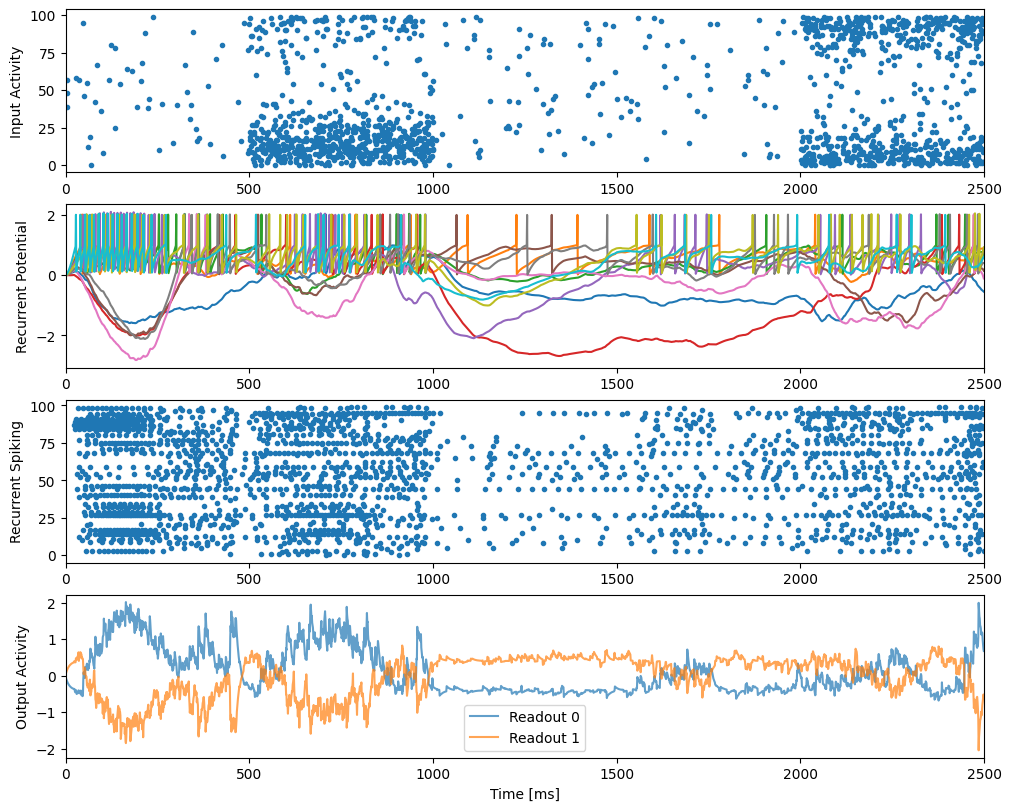

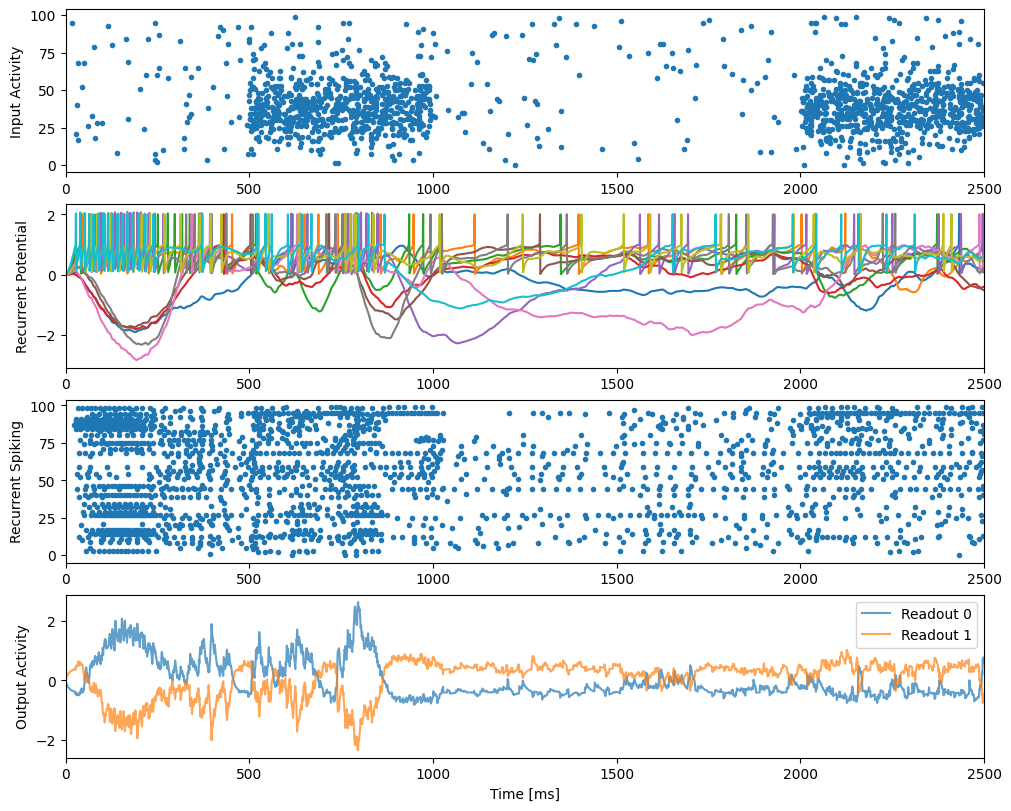

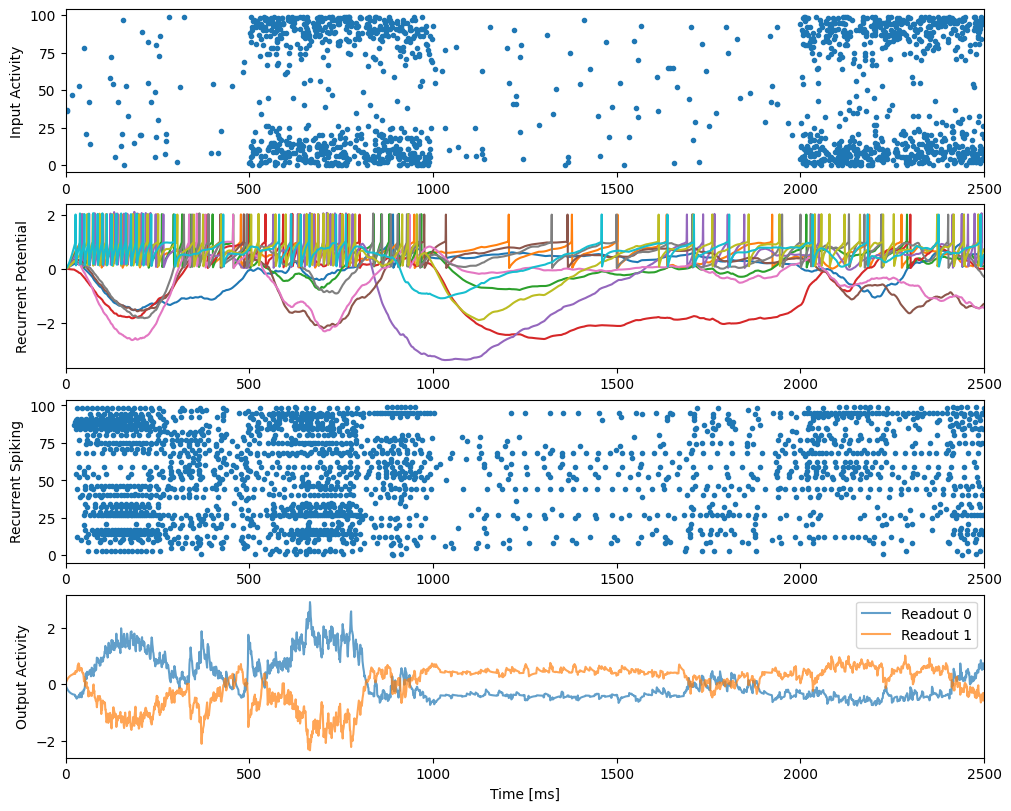

In [14]:
verify_lif(net, ds, fn=None, num_show=3, sps_inc=2.)

## Verify GIF firing patterns

In [18]:
import functools

In [15]:
def f_run(i, current, neuron):
  neuron.step_run(i, current)
  return neuron.V.flatten()

In [19]:
with bm.environment(bm.NonBatchingMode()):
    neuron = GIF(1, Ath=1, A2=-0.6, A1=0., tau_I1=10., tau_I2=2000)
indices = bm.arange(10000).to_numpy()
currents = bm.ones(10000).to_numpy() * 3.
vs1 = bm.for_loop(functools.partial(f_run, neuron=neuron), [indices, currents]).to_numpy()

In [21]:
with bm.environment(bm.NonBatchingMode()):
    neuron = GIF(1, Ath=1, A2=-0.6, A1=8., tau_I1=10., tau_I2=1000)
indices = bm.arange(10000).to_numpy()
currents = bm.ones(10000).to_numpy() * 2.
vs2 = bm.for_loop(functools.partial(f_run, neuron=neuron), [indices, currents]).to_numpy()

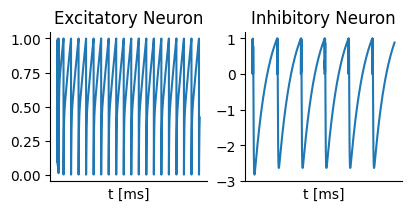

In [22]:
fig, gs = bp.visualize.get_figure(1, 2, 2., 2.)
ax = fig.add_subplot(gs[0, 0])
plt.plot(indices * bm.dt, vs1)
plt.title('Excitatory Neuron')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks([])
plt.xlabel('t [ms]')
ax = fig.add_subplot(gs[0, 1])
plt.plot(indices * bm.dt, vs2)
plt.title('Inhibitory Neuron')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks([])
plt.xlabel('t [ms]')
plt.show()